# Exploratory Data Analysis of fakenewskdd dataset

In [4]:
import numpy as np
import pandas as pd

#Plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

#Wordcloud
from wordcloud import WordCloud, STOPWORDS

#Work with text
from nltk.tokenize import RegexpTokenizer
import re #regexp
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer 

#Paralelize pandas apply on multiple cores
import swifter

import random

#reader
def read_pairs(path, separator='\t', cast=(str, str), offset=0):
    with open(path) as f:
        return [(cast[0](k), cast[1](v)) for line in f.readlines()[offset:] for k, v in [line.rstrip().split(separator)]]


### Importing the dataset

In this section, we will mostly be exploring the training dataset, because we do not have the labels for the test dataset. Therefore, we will not be able to obtain meaningful insights from it.

In [5]:
train_path ="../data/final/train.csv"

raw_data_train = dict(read_pairs(train_path, cast=(str, int), offset=1))
data_train = {
    'text': pd.Index(list(raw_data_train.keys())),
    'label': pd.Index(list(raw_data_train.values()))
}

df = pd.DataFrame(data_train)


In [6]:
df.head()

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It’s safe to say that Instagram Stories has fa...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0


In [8]:
#Select only relevant columns
df = df[['label', 'text']]
#Remove columns with NaNs 
df.loc[df['label']==1, 'type'] = 'real'
df.loc[df['label']==0, 'type'] = 'fake'

/Users/chengling/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/chengling/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [9]:
df.head()

,label,text,type
0,1,Get the latest from TODAY Sign up for our news...,real
1,1,2d Conan On The Funeral Trump Will Be Invited...,real
2,0,It’s safe to say that Instagram Stories has fa...,fake
3,0,Much like a certain Amazon goddess with a lass...,fake
4,0,At a time when the perfect outfit is just one ...,fake


### Number of fake news and real news in the dataset

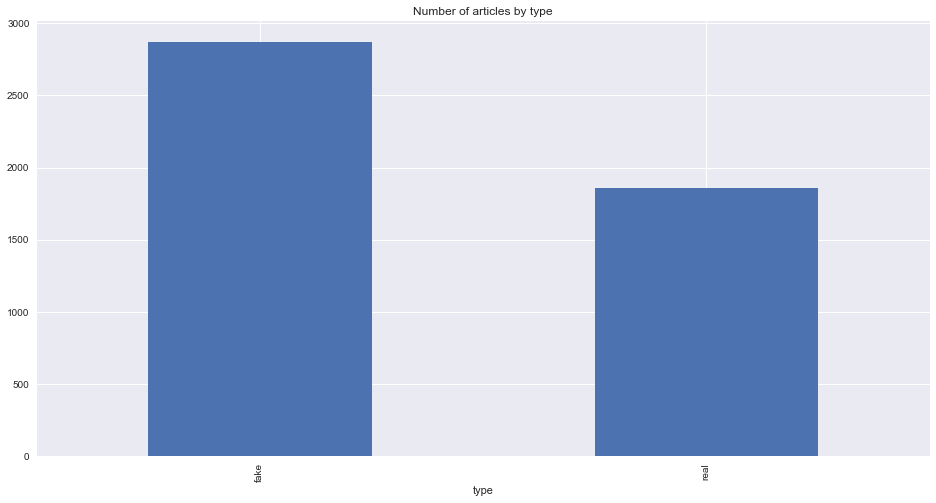

In [11]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
df.groupby("type").count()['text'].plot.bar(title = "Number of articles by type", ax = ax)

The amount of fake news is clearly over represented in the dataset. This may pose some problems to use later.

## Linguistic Analysis

Helper Functions

In [13]:
stop_words = STOPWORDS.union(set(["will"]))
ps = PorterStemmer()

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]    
    
    return ' '.join(words)


def clean_text_array(text):
    """ Lo mismo que clean_text pero retorna un array
    """
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    #Tokenize
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    #Remove non alphanumerica characters
    words = [word.lower() for word in tokens if word.isalpha()]  
    return words


def tokenize(text):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    tokens = tokenizer.tokenize(text)
    return tokens


def split_phrases(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = '. '.join(text.split("\n")).split(".")
    text = [x for x in text if x not in [".", "\n", "", " "]]
    return text

### Most Frequent Words by News Type

In [14]:
corpus_text = [clean_text_array(i) for i in df[df['type'] == 'fake']['text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_fake = c.most_common(20)

corpus_text = [clean_text_array(i) for i in df[df['type'] == 'real']['text'].tolist()]
corpus_text = [item for sublist in corpus_text for item in sublist]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]
c = Counter(corpus_text)
most_common_truth = c.most_common(20)

In [15]:
most_common_truth

[('said', 2983),
 ('one', 2765),
 ('new', 2472),
 ('time', 2470),
 ('first', 2111),
 ('people', 2059),
 ('trump', 1796),
 ('film', 1717),
 ('two', 1692),
 ('years', 1653),
 ('show', 1593),
 ('now', 1588),
 ('told', 1544),
 ('year', 1506),
 ('life', 1496),
 ('love', 1479),
 ('us', 1462),
 ('family', 1449),
 ('best', 1394),
 ('source', 1349)]

In [16]:
most_common_fake

[('said', 5354),
 ('one', 4756),
 ('new', 4102),
 ('first', 3862),
 ('time', 3857),
 ('people', 3787),
 ('show', 3366),
 ('two', 2845),
 ('now', 2707),
 ('know', 2668),
 ('season', 2560),
 ('going', 2491),
 ('year', 2311),
 ('back', 2303),
 ('years', 2272),
 ('think', 2235),
 ('us', 2171),
 ('family', 2081),
 ('love', 1980),
 ('don', 1962)]

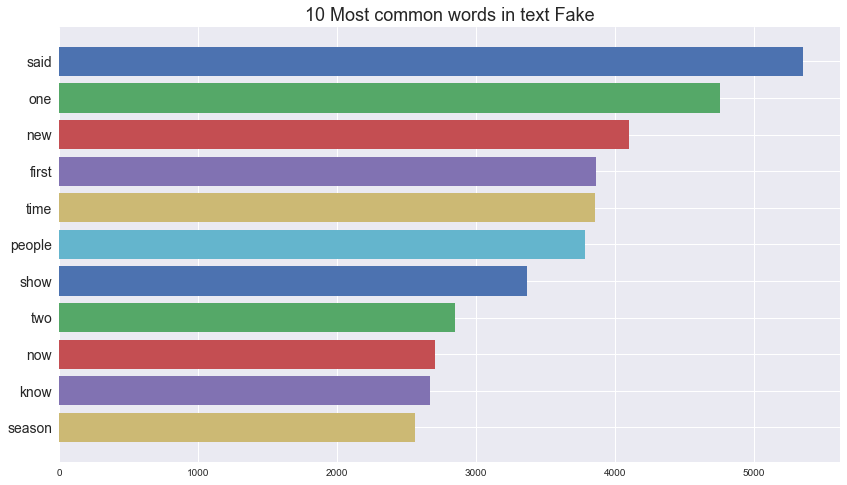

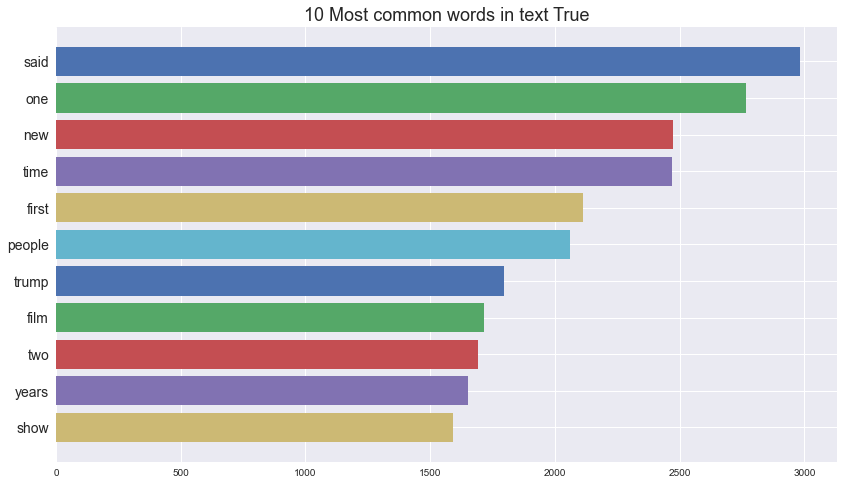

In [17]:
names = ["10 Most common words in text Fake", "10 Most common words in text True"]
variables = [most_common_fake, most_common_truth]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    
    for index, item in enumerate(var):
        if index > 10: break
        ax.barh(width=item[1], y=item[0])
        ax.invert_yaxis()
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

This seems problematic and that our model may receive alot of noise because words like "said" and "one" are not stop words, but do not bring much meaning to the text anyway.

### Analysis of Tri-grams

Trigrams are a special case of the n-gram, where n is 3. They are used to perform statistical analysis on the text.

In [18]:
corpus_text = [clean_text(i) for i in df[df['type'] == 'fake']['text'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_fake = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_fake[ng_text] = ng_count

In [19]:
corpus_text = [clean_text(i) for i in df[df['type'] == 'real']['text'].tolist()]
corpus_text = [w.lower().strip() for w in corpus_text if w.lower().strip() not in stop_words ]

c_vec = CountVectorizer(ngram_range=(3,3))
ngrams = c_vec.fit_transform(corpus_text)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

# save n-grams
ngrams_true = {}
i=0
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    i+=1
    if i>30:
        break
    ngrams_true[ng_text] = ng_count

In [20]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'one of the': 431,
 'the united states': 345,
 'as well as': 258,
 'in new york': 255,
 'at the time': 234,
 'according to the': 227,
 'in los angeles': 215,
 'the end of': 201,
 'new york city': 198,
 'up with the': 197,
 'of the year': 197,
 'the new york': 195,
 'in the united': 176,
 'the first time': 171,
 'with the kardashians': 165,
 'in the world': 161,
 'out of the': 157,
 'keeping up with': 156,
 'part of the': 149,
 'in the film': 149,
 'years of marriage': 147,
 'new york times': 140,
 'the fact that': 137,
 'award for best': 137,
 'of the most': 135,
 'post shared by': 129,
 'the white house': 128,
 'in an interview': 127,
 'source close to': 122,
 'that she was': 121}

In [21]:
print("TRIGRAMS TRUE")
ngrams_true

TRIGRAMS TRUE


{'one of the': 431,
 'the united states': 345,
 'as well as': 258,
 'in new york': 255,
 'at the time': 234,
 'according to the': 227,
 'in los angeles': 215,
 'the end of': 201,
 'new york city': 198,
 'up with the': 197,
 'of the year': 197,
 'the new york': 195,
 'in the united': 176,
 'the first time': 171,
 'with the kardashians': 165,
 'in the world': 161,
 'out of the': 157,
 'keeping up with': 156,
 'part of the': 149,
 'in the film': 149,
 'years of marriage': 147,
 'new york times': 140,
 'the fact that': 137,
 'award for best': 137,
 'of the most': 135,
 'post shared by': 129,
 'the white house': 128,
 'in an interview': 127,
 'source close to': 122,
 'that she was': 121}

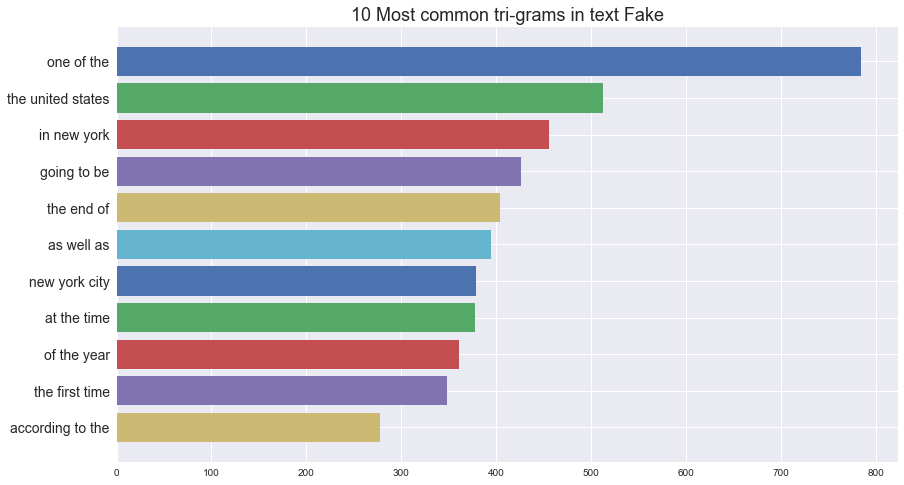

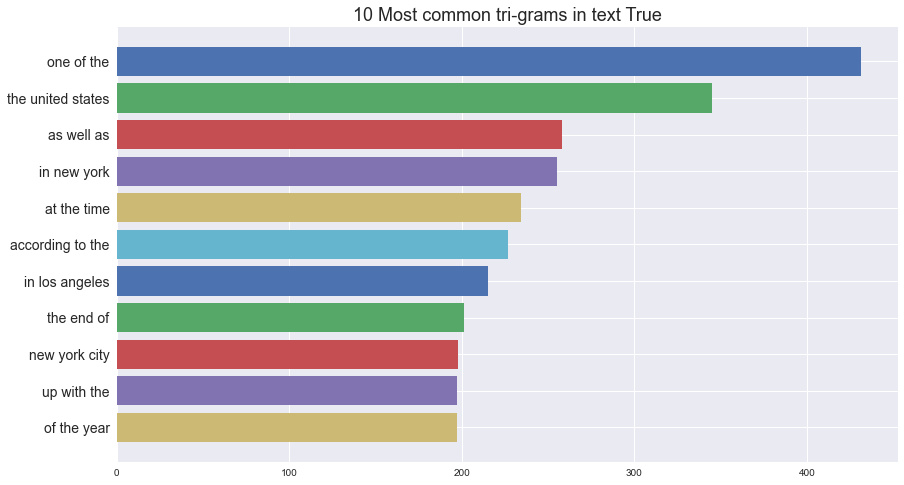

In [22]:
names = ["10 Most common tri-grams in text Fake", "10 Most common tri-grams in text True"]
variables = [ngrams_fake, ngrams_true]

for title, var in zip(names, variables):
    fig, ax = plt.subplots(figsize=(14,8))
    idx = 0
    for index, item in var.items():
        if idx > 10: break
        ax.barh(width=item, y=index)
        ax.invert_yaxis()
        idx += 1
    plt.tick_params(axis='y', which='major', labelsize=14)
    plt.title(title, fontsize=18)
    plt.show()

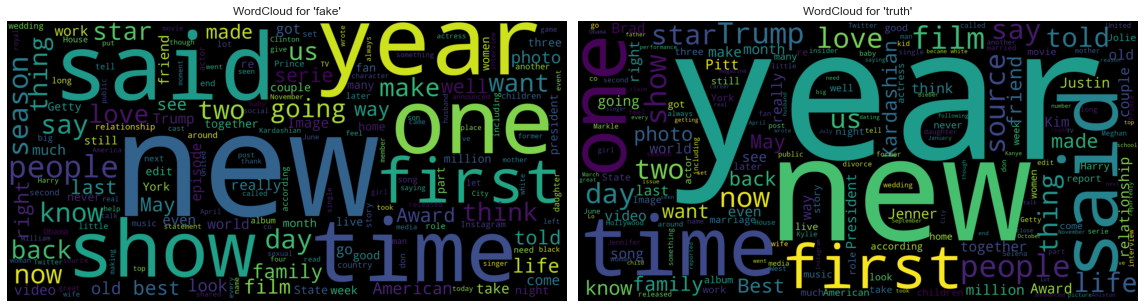

In [23]:
fig, ax = plt.subplots(1,2, figsize=(16,16))

corpus_text = ''.join(df[df['type'] == 'fake']['text'].tolist())
corpus_text = re.sub('(043)\w+|(044)\w+', '', corpus_text)  
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[0].imshow(wordcloud, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title("WordCloud for 'fake'")

corpus_text = ''.join(df[df['type'] == 'real']['text'].tolist())
wordcloud = WordCloud(stopwords=stop_words, scale = 7, collocations=False).generate(corpus_text)
ax[1].imshow(wordcloud, interpolation='bilinear')
ax[1].axis("off")
ax[1].set_title("WordCloud for 'truth'")

plt.tight_layout()

### Overall Length of Words in Text Content

In [28]:
df['clean_content'] = df.apply(lambda row: clean_text(row['text']), axis=1)
df['len_content'] = df.apply(lambda row: len(row['clean_content']), axis=1)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 0.98, '')

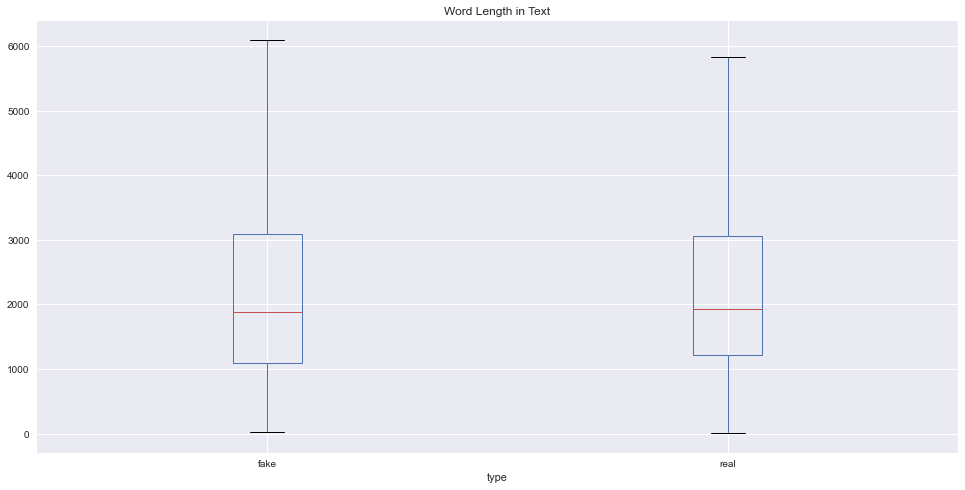

In [30]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
df.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Overall Length of Words in Text Content")
plt.suptitle("")

In [32]:
df = df.drop(["clean_content","len_content"], axis=1)

### Sentence length distribution by article type

In [35]:
corpus_text = '. '.join([i for i in df[df['type'] == 'fake']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_fake = [len(tokenize(s)) for s in corpus_text]

corpus_text = '. '.join([i for i in df[df['type'] == 'real']['text'].tolist()])
corpus_text = split_phrases(corpus_text)
lengths_truth = [len(tokenize(s)) for s in corpus_text]

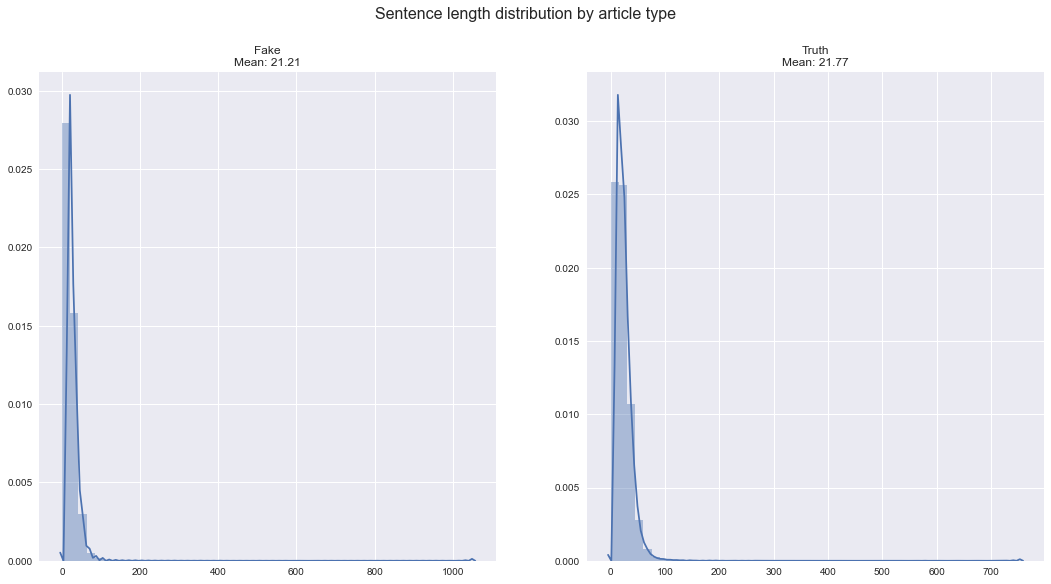

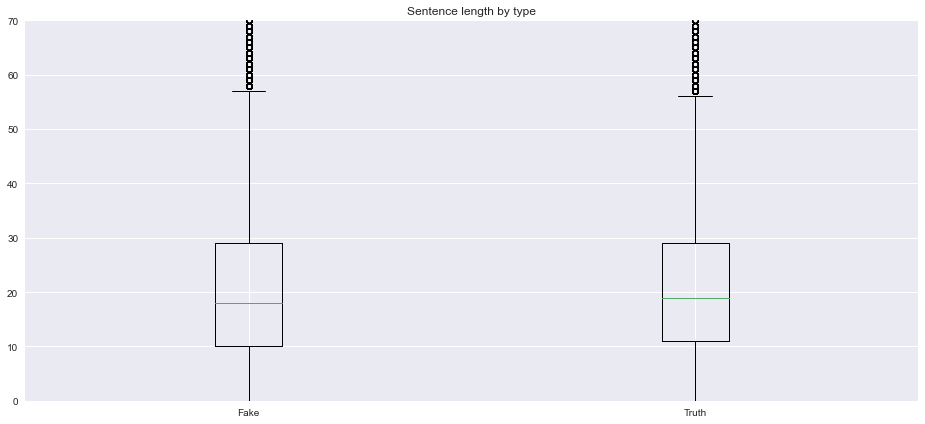

In [36]:
fig, ax = plt.subplots(1,2, figsize=(18,9))
fig.suptitle("Sentence length distribution by article type", size=16)

sns.distplot(lengths_fake, ax=ax[0])
ax[0].set_title("Fake\nMean: {0:.2f}".format(np.average(lengths_fake)))


sns.distplot(lengths_truth, ax=ax[1])
ax[1].set_title("Truth\nMean: {0:.2f}".format(np.average(lengths_truth)))

plt.show()


#Boxplot
fig, ax = plt.subplots(1,1, figsize=(16,7))
plt.title("Sentence length by type")
plt.ylim((0,70))
plt.boxplot([lengths_fake, lengths_truth], 
            labels=['Fake', 'Truth'])
plt.show()

### Article length in phrases

In [39]:
df['len_content'] = df.apply(lambda row: len(row['text'].split(". ")), axis=1)


Text(0.5, 0.98, '')

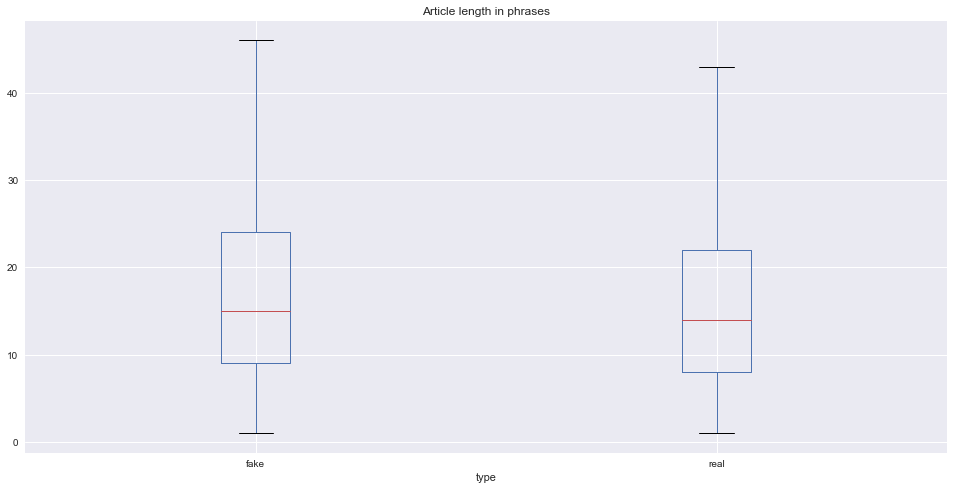

In [40]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
df.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Article length in phrases")
plt.suptitle("")

### Number of exclamation marks 

In [96]:
df['len_content'] = df.text.str.count("!|\?")

Text(0.5, 0.98, '')

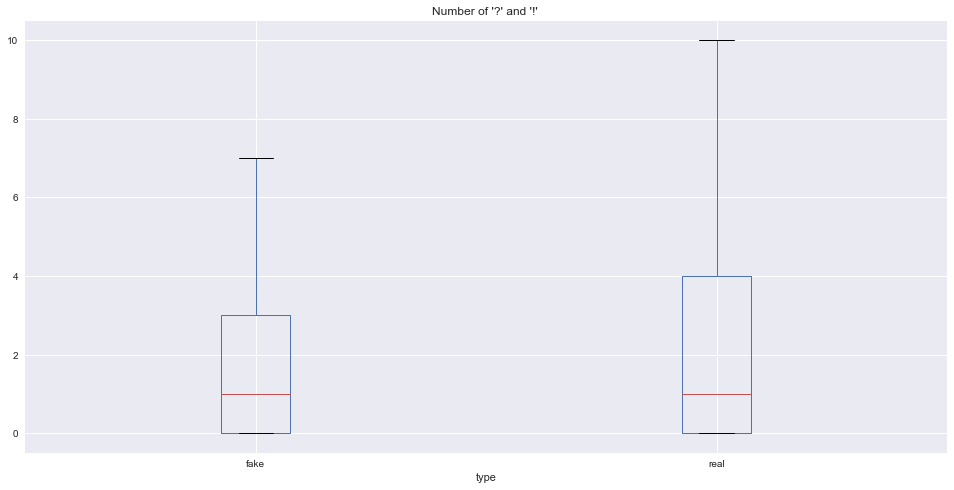

In [97]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
df.boxplot(column=['len_content'], by='type', ax=ax, showfliers=False)
plt.title("Number of '?' and '!' ")
plt.suptitle("")

In [99]:
df['len_exclaim'] = df.text.str.count("!")
df['len_question']= df.text.str.count("\?")

In [100]:
df=df.drop(['len_content'], axis=1)

## Word Use Analysis

Analysing the dataset by noun usage.

* First person: "I, me, my, mine, we, us, our, ours"
* Second person: "you, you, your, yours"
* Third person: "he, she, his, her, him, his, hers, they, them, their, theirs"

In [101]:
def count_person_forms(text, person):
    text = tokenize(text.lower())
    counter = 0
    for word in text:
        if word in person:
            counter += 1
    return counter

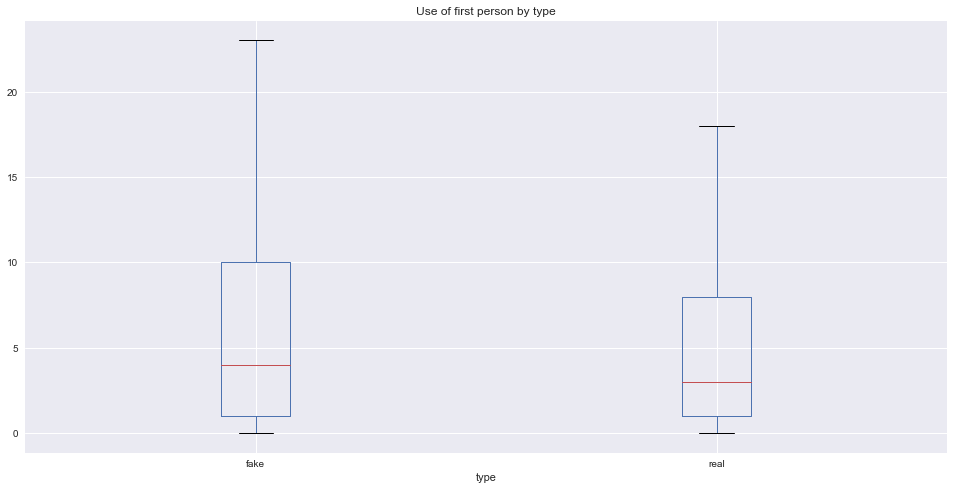

In [102]:
first_person = ["i", "me", "mine", "we", "us", "our", "ours"]
second_person = ["you", "your", "yours"]

df['first_person'] = df.apply(lambda row: count_person_forms(row['text'], first_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
df.boxplot(column=['first_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of first person by type")
fig.suptitle("")
plt.show()

In [103]:
df.groupby('type')['first_person'].mean()

type
fake    11.612735
real     7.642434
Name: first_person, dtype: float64

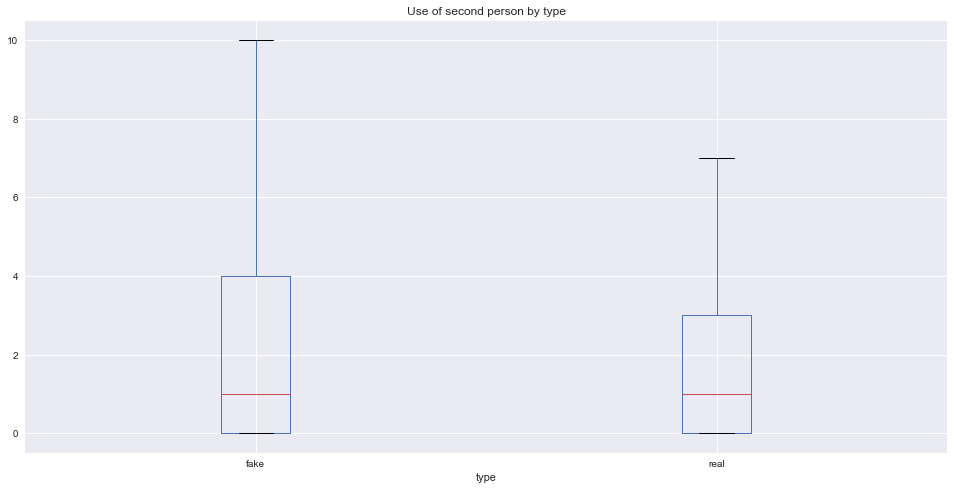

In [104]:
df['second_person'] = df.apply(lambda row: count_person_forms(row['text'], second_person), axis=1)
fig, ax = plt.subplots(1,1, figsize=(16,8))
df.boxplot(column=['second_person'], by='type', ax=ax, showfliers=False)
ax.set_title("Use of second person by type")
fig.suptitle("")
plt.show()

In [105]:
df=df.drop(['second_person'], axis=1)

### Sentiment Analysis

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chengling/nltk_data...


True

In [58]:
def classify_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    text = text.replace("\n\n", ". ").replace("\n", ". ")
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    pol = sid.polarity_scores(text)['compound']
    return pol

In [59]:
df['sent'] = df.apply(lambda r: classify_sentiment(r['text']), axis=1)

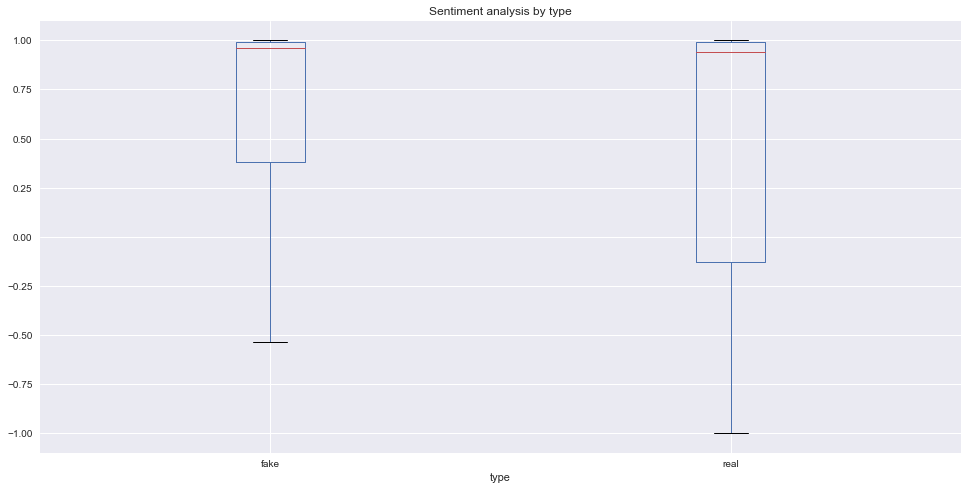

In [60]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
df.boxplot(column=['sent'], by='type', ax=ax, showfliers=False)
ax.set_title("Sentiment analysis by type")
fig.suptitle("")
plt.show()

### Analysis of diversity in vocabulary

In [61]:
def lexical_diversity(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = tokenize(text.lower())
    if len(text) == 0:
        return 0
    return len(set(text)) / len(text)

def percentage(count, total):
    return 100 * count / total

In [62]:
df['lexical_diver'] = df.apply(lambda r: lexical_diversity(r['text']), axis=1)

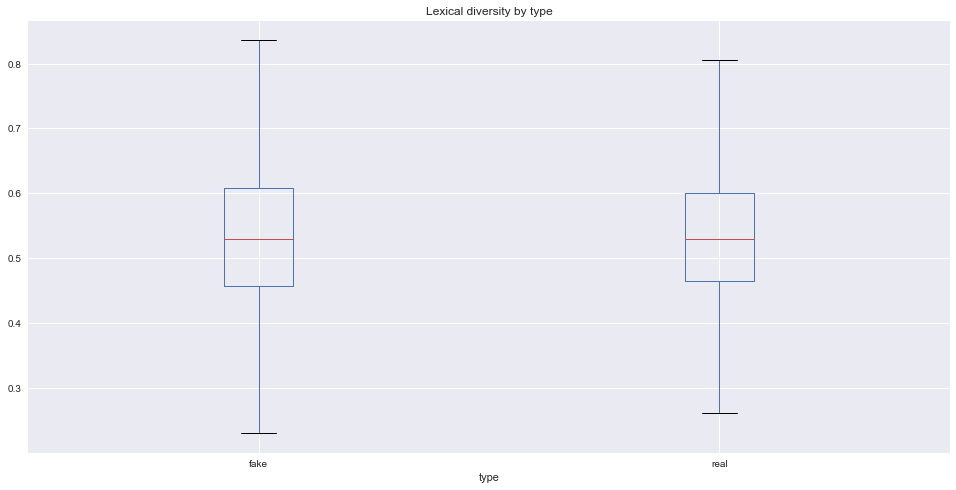

In [63]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = df.boxplot(column=['lexical_diver'], by='type', ax=ax, showfliers=False)
ax.set_title("Lexical diversity by type")
fig.suptitle("")
plt.show()

In [69]:
df.groupby('type')['lexical_diver'].mean()

type
fake    0.541754
real    0.542333
Name: lexical_diver, dtype: float64

### Analysis of usage of superlatives

Superlatives are words that express comparison...

In [70]:
from textblob import TextBlob

In [71]:
def textblob_adj(text):
    blobed = TextBlob(text)
    counts = Counter(tag for word,tag in blobed.tags)
    super_list = []
    super_tag_list = ['JJS','RBS']
    for (a, b) in blobed.tags:
        if b in super_tag_list:
           super_list.append(a)
    return counts['JJS'] + counts['RBS']

def list_superlatives(text):
    add_list = []
    for txt in text:
        add_list.append(textblob_adj(txt))
    return add_list

In [75]:
df = df.assign(use_super = list_superlatives(df.text))

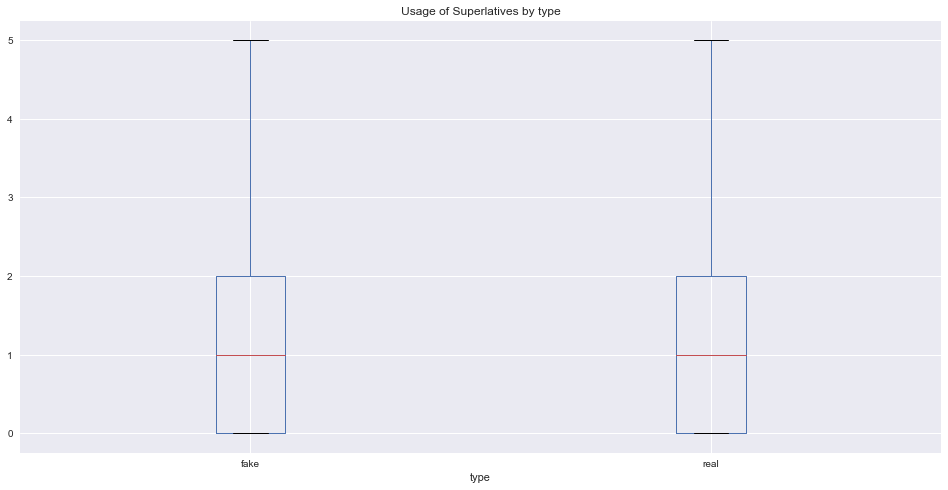

In [76]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax = df.boxplot(column=['use_super'], by='type', ax=ax, showfliers=False)
ax.set_title("Usage of Superlatives by type")
fig.suptitle("")
plt.show()

## PCA Analysis of text embeddings

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].astype(str).tolist()
list_labels = df["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)


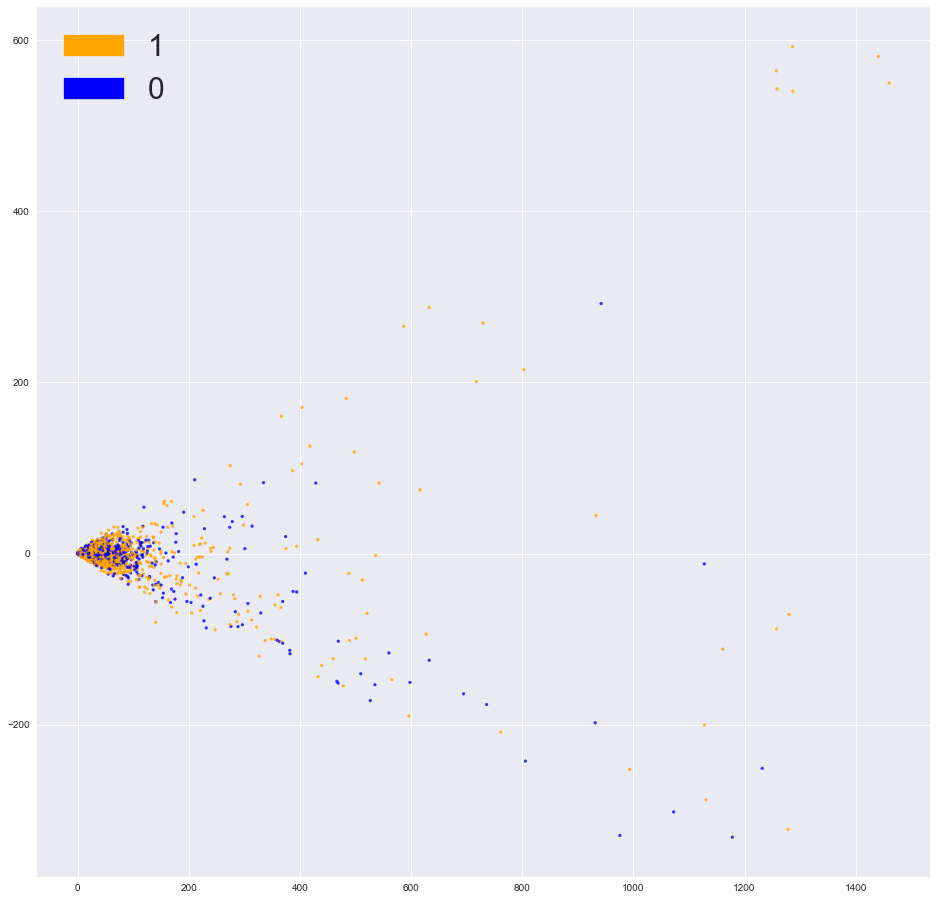

In [90]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='1')
            green_patch = mpatches.Patch(color='blue', label='0')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

## Conclusion

From the dataset, we see that there may be not much difference in fake and real news therefore, it may be tough to classify by our models. After visualisation of the text's latent features, we have decided to use the following handpicked features to use in another layer alongside just the usage of regular deep learning techniques on the dataset.

* First person pronouns used
* Exclamation points (? and !), counted separately 
* Counts of superlatives in the text
* Lexical diversity in the text
* Sentiment of text

In [107]:
df=df.drop(['type'], axis=1)

In [111]:
df["text"] = df["text"].str.lower()

In [112]:
df.head()

,label,text,sent,lexical_diver,use_super,len_exclaim,len_question,first_person
0,1,get the latest from today sign up for our news...,0.1531,0.537662,1,0,0,8
1,1,2d conan on the funeral trump will be invited...,-0.3612,0.857143,0,0,0,0
2,0,it’s safe to say that instagram stories has fa...,0.9879,0.536862,1,6,2,5
3,0,much like a certain amazon goddess with a lass...,0.9992,0.348816,5,2,2,32
4,0,at a time when the perfect outfit is just one ...,0.7234,0.682927,0,0,0,0


In [113]:
filename = 'data_cleaned.csv'
df.to_csv(filename,index=False)